# Toying with Image Augmentation

## Without Image Augmentation

### Dataset Download

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
! wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip -O cats-and-dogs.zip

--2023-12-30 13:32:11--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.25.209.13, 2600:1409:9800:98c::317f, 2600:1409:9800:984::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.25.209.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: 'cats-and-dogs.zip'

cats-and-dogs.zip   100%[===================>] 786.67M   131MB/s    in 5.7s    

2023-12-30 13:32:17 (139 MB/s) - 'cats-and-dogs.zip' saved [824887076/824887076]



In [4]:
! unzip -q cats-and-dogs.zip -d cats-and-dogs-dataset

### Dataset Cleaning

In [5]:
CATS_PATH = './cats-and-dogs-dataset/PetImages/Cat'
DOGS_PATH = './cats-and-dogs-dataset/PetImages/Dog'

cats_data = os.listdir(CATS_PATH)
dogs_data = os.listdir(DOGS_PATH)

print('CATS',len(cats_data))
print('DOGS',len(dogs_data))

CATS 12501
DOGS 12501


Open CV fails to detect an erroneous image file

In [6]:
import cv2
try:
    cv2.imread('./cats-and-dogs-dataset/PetImages/Cat/666.jpg')
except Exception:
    print(str(Exception), 'Problem')

PIL.image successfully detects erroneous images

In [7]:
from PIL import Image

with Image.open('./cats-and-dogs-dataset/PetImages/Cat/666.jpg') as img:
    img.verify()

UnidentifiedImageError: cannot identify image file './cats-and-dogs-dataset/PetImages/Cat/666.jpg'

In [8]:
from PIL import Image

for cat_name in cats_data:
    file_path = os.path.join(CATS_PATH, cat_name)
    try:
        with Image.open(file_path) as img:
            img.verify()
    except:
        print('Removing corrupt image',cat_name)
        os.remove(file_path)

for dog_name in dogs_data:
    file_path = os.path.join(DOGS_PATH, dog_name)
    try:
        with Image.open(file_path) as img:
            img.verify()
    except:
        print('Removing corrupt image',dog_name)
        os.remove(file_path)

Removing corrupt image Thumbs.db
Removing corrupt image 666.jpg
Removing corrupt image 11702.jpg
Removing corrupt image Thumbs.db


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


### Creating Image Generators Here

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2    
)

train_gen = data_gen.flow_from_directory(
    './cats-and-dogs-dataset/PetImages/',
    batch_size=128,
    target_size=(256,256),
    class_mode='binary',
    subset='training'
)

val_gen = data_gen.flow_from_directory(
    './cats-and-dogs-dataset/PetImages/',
    batch_size=128,
    target_size=(256,256),
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


### Model Initialization

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(5,5),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 64)      204864    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 19, 19, 32)        0

In [11]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Callback

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs['val_accuracy'] > 0.8):
            self.model.stop_training = True

custom_callback = myCallback()

### Model Training

In [13]:
hist_data = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=128, epochs=20, callbacks=[custom_callback])

Epoch 1/20


KeyboardInterrupt: 

### Plotting data

In [ ]:
plt.plot(hist_data.history['accuracy'],label='training')
plt.plot(hist_data.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

## With image augmentation

In [14]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(5,5),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 123, 123, 64)      204864    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 59, 59, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 19, 19, 32)       

In [15]:
model2.compile(optimizer=RMSprop(learning_rate=1e-3), loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
new_data_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=45,
    height_shift_range=0.5,
    width_shift_range=0.5,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

new_train_gen = new_data_gen.flow_from_directory(
    './cats-and-dogs-dataset/PetImages/',
    batch_size=128,
    target_size=(256,256),
    class_mode='binary',
    subset='training'
)

Found 20000 images belonging to 2 classes.


In [17]:
new_data_hist = model2.fit(new_train_gen,validation_data=val_gen,steps_per_epoch=128,epochs=20)

Epoch 1/20
128/128 [==============================] - 279s 2s/step - loss: 0.9792 - accuracy: 0.5118 - val_loss: 0.6887 - val_accuracy: 0.5872
Epoch 2/20
128/128 [==============================] - 278s 2s/step - loss: 0.6863 - accuracy: 0.5551 - val_loss: 0.6604 - val_accuracy: 0.6140
Epoch 3/20
128/128 [==============================] - 277s 2s/step - loss: 0.6723 - accuracy: 0.5718 - val_loss: 0.6877 - val_accuracy: 0.5342
Epoch 4/20
128/128 [==============================] - 277s 2s/step - loss: 0.6664 - accuracy: 0.5842 - val_loss: 0.6184 - val_accuracy: 0.6773
Epoch 5/20
128/128 [==============================] - 280s 2s/step - loss: 0.6555 - accuracy: 0.6097 - val_loss: 0.6097 - val_accuracy: 0.6583
Epoch 6/20
128/128 [==============================] - 278s 2s/step - loss: 0.6520 - accuracy: 0.6175 - val_loss: 0.6205 - val_accuracy: 0.6531
Epoch 7/20
128/128 [==============================] - 280s 2s/step - loss: 0.6480 - accuracy: 0.6243 - val_loss: 0.6152 - val_accuracy: 0.6325

### Plotting new data here

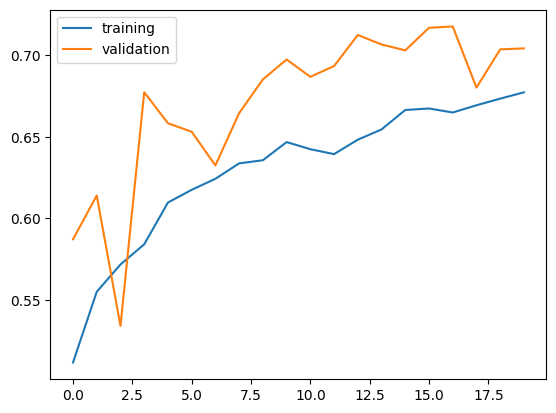

In [18]:
plt.plot(new_data_hist.history['accuracy'],label='training')
plt.plot(new_data_hist.history['val_accuracy'],label='validation')
plt.legend()
plt.show()

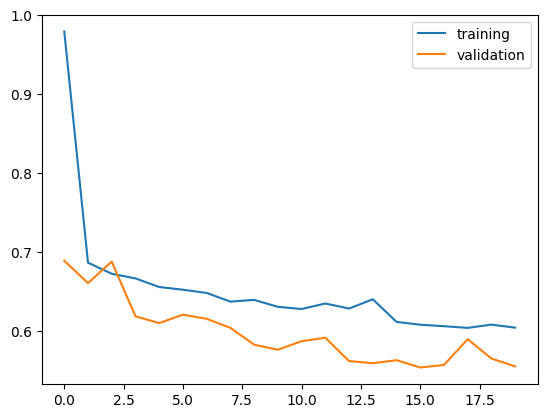

In [19]:
plt.plot(new_data_hist.history['loss'],label='training')
plt.plot(new_data_hist.history['val_loss'],label='validation')
plt.legend()
plt.show()